In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from exp.nb_callbacks import *
from exp.nb_utils import listify
from exp.nb_metrics import Metric, AvgMetric

In [4]:
def make_metric(m):
    return m if isinstance(m, Metric) else AvgMetric(m)

In [5]:
#export
class Learner:
    _default_cbs = [TrainEvalCallback]

    ALL_CBS = {
    'begin_fit', 'begin_epoch', 'begin_train', 'begin_batch',
    'after_pred', 'after_loss', 'after_backward', 'after_step',
    'after_batch', 'after_train', 'begin_validate', 'after_validate',
    'after_epoch', 'after_fit', 'after_cancel_fit',
    'after_cancel_batch', 'after_cancel_epoch', 'after_cancel_train', 'after_cancel_validate'}

    def __init__(self, model, data, loss_func, opt_func, lr=1e-2, metrics=None, cbs=None, cb_funcs=None):
        self.model, self.data, self.loss_func, self.opt_func, self.lr, self.metrics = model, data, loss_func, opt_func, lr, metrics

        self.opt = None
        self.cbs = []
        self.in_train = False
        self.logger = print

        self.add_cbs([cb() for cb in self._default_cbs])
        self.add_cbs(cbs)
        self.add_cbs([cbf() for cbf in listify(cb_funcs)])

    @property
    def metrics(self): return self._metrics

    @metrics.setter
    def metrics(self, metrics):
        self._metrics = list(map(make_metric, metrics))

    def set_logger(self, logger):
        self.logger = logger

    def add_cb(self, cb):
        cb.set_learner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)

    def get_params(self):
        return self.model.parameters()

    def _do_begin_fit(self, epochs):
        self.epochs = epochs
        self.loss = tensor(0.)
        self('begin_fit')

    def _do_epoch_train(self):
        try:
            self.dl = self.data.train_dl;                           self('begin_train')
            self.all_batches()
        except CancelTrainException:                                self('after_cancel_train')
        finally:                                                    self('after_train')

    def _do_epoch_validate(self):
        try:
            self.dl = self.data.valid_dl;                           self('begin_validate')
            with torch.no_grad():
                self.all_batches()
        except CancelValidException:                                self('after_cancel_validate')
        finally:                                                    self('after_validate')

    def one_batch(self, i, xb, yb):
        self.iter = i
        try:
            self.xb, self.yb = xb, yb;                              self('begin_batch')
            self.pred = self.model(self.xb);                        self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb);         self('after_loss')
            # If validate
            if not self.in_train: return
            self.loss.backward();                                   self('after_backward')
            self.opt.step();                                        self('after_step')
            self.opt.zero_grad();
        except CancelBatchException:                                self('after_cancel_batch')
        finally:                                                    self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        for i, (xb, yb) in enumerate(self.dl):
            self.one_batch(i, xb, yb);

    def _end_cleanup(self):
        self.dl, self.xb, self.yb, self.pred, self.loss = None, (None,), (None,), None, None

    def fit(self, epochs, cbs=None, reset_opt=False):
        self.add_cbs(cbs)
        if reset_opt or not self.opt:
            self.opt = self.opt_func(self.get_params(), lr=self.lr)

        try:
            self._do_begin_fit(epochs)
            for epoch in range(epochs):
                try:
                    self.epoch = epoch;                             self('begin_epoch')
                    self._do_epoch_train()
                    self._do_epoch_validate()
                except CancelEpochException:                        self('after_cancel_epoch')
                finally:                                            self('after_epoch')
        except CancelFitException:                                  self('after_cancel_fit')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)
            self._end_cleanup()

    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order):
            res = cb(cb_name) and res
        return res

In [6]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds[0][0].shape[0]
    print(data.train_ds[0][0].shape)
    model = nn.Sequential(nn.Conv2d(m,nh, 7, 2), nn.ReLU(),
                          nn.Conv2d(nh,nh*2, 5, 2), nn.ReLU(),
                          nn.Conv2d(nh*2,nh*2*2, 3, 2), nn.ReLU(),
                          nn.Conv2d(nh*4,nh*8, 3, 2), nn.ReLU(),
                          nn.AdaptiveAvgPool2d(1),
                          nn.Flatten(), nn.Linear(400,data.c))
    return model

In [10]:
from exp.nb_dataset import get_skin_databunch
db = get_skin_databunch(size=64*2)

In [11]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [12]:
from functools import partial

In [13]:
mdl = get_model(db)

torch.Size([3, 450, 600])


In [14]:
import torchvision.models as models
from torchvision import transforms as T

resnet18 = models.resnet18(pretrained=True)
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [15]:
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 7)

In [17]:
# Somewhat more flexible way
device = torch.device('cuda',0); device

device(type='cuda', index=0)

In [18]:
torch.cuda.set_device(device)

In [23]:
db = get_skin_databunch(size=None)

In [25]:
learner = Learner(resnet18, db, F.cross_entropy, optim.Adam, metrics=[accuracy], cb_funcs=[Recorder, ProgressCallback, CudaCallback])
learner.fit(10)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.059866,0.649125,0.027936,0.806890,03:30
1,1.117370,0.649686,0.074073,0.767906,03:30
2,0.991430,0.652828,0.045754,0.794198,03:28
3,0.966990,0.650247,0.032795,0.794198,03:24
4,0.931777,0.654399,0.029597,0.794198,03:24
5,0.920736,0.660570,0.027382,0.807797,03:27
6,0.915058,0.673025,0.021236,0.816863,03:28
7,0.892721,0.673362,0.041427,0.806890,03:31
8,0.876201,0.682899,0.036792,0.815050,03:29
9,0.853617,0.677289,0.028378,0.814143,03:31


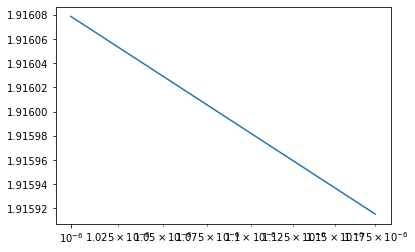

In [18]:
learner.recorder.plot()

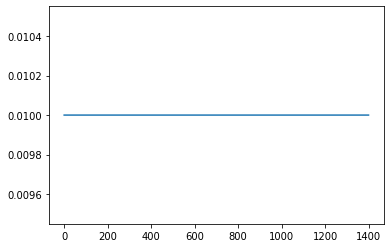

In [29]:
plt.plot(learner.recorder.lrs)

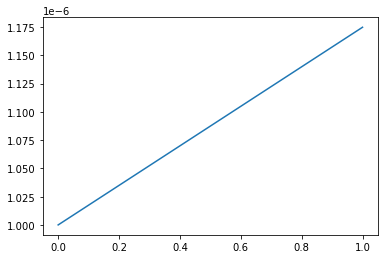

In [20]:
learner.recorder.plot_lr()

In [88]:
!python notebook2script.py learner.ipynb

Converted learner.ipynb to exp\nb_learner.py


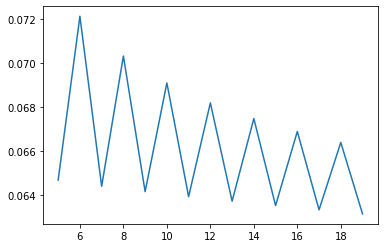

In [90]:
learner.recorder.plot_loss(with_valid=False)

In [91]:
learner.recorder.values

[[0.06565000861883163, 0.6640625, 2.1903767585754395, 0.6640625],
 [0.06505130231380463, 0.6640625, 2.213296890258789, 0.6640625],
 [0.06469689309597015, 0.6640625, 2.232323169708252, 0.6640625],
 [0.06441657245159149, 0.6640625, 2.248276710510254, 0.6640625],
 [0.06417249888181686, 0.6640625, 2.2617905139923096, 0.6640625],
 [0.06395000219345093, 0.6640625, 2.2733583450317383, 0.6640625],
 [0.06374165415763855, 0.6640625, 2.283360242843628, 0.6640625],
 [0.0635431557893753, 0.6640625, 2.2920992374420166, 0.6640625],
 [0.06335177272558212, 0.6640625, 2.299820899963379, 0.6640625],
 [0.06316570192575455, 0.6640625, 2.306722640991211, 0.6640625]]

In [93]:
idx = (np.array(learner.recorder.iters)<5).sum()
idx

2

In [94]:
learner.recorder.values[idx:]

[[0.06469689309597015, 0.6640625, 2.232323169708252, 0.6640625],
 [0.06441657245159149, 0.6640625, 2.248276710510254, 0.6640625],
 [0.06417249888181686, 0.6640625, 2.2617905139923096, 0.6640625],
 [0.06395000219345093, 0.6640625, 2.2733583450317383, 0.6640625],
 [0.06374165415763855, 0.6640625, 2.283360242843628, 0.6640625],
 [0.0635431557893753, 0.6640625, 2.2920992374420166, 0.6640625],
 [0.06335177272558212, 0.6640625, 2.299820899963379, 0.6640625],
 [0.06316570192575455, 0.6640625, 2.306722640991211, 0.6640625]]